In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [3]:
img_size = (320, 320)
input_size = 320
batch_size = 32

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# directory = "/content/drive/Othercomputers/Iliya-PC/GrayPhoto"
directory = "/content/drive/MyDrive/projects"
input_dir = os.path.join(directory, "training_real_faces")
input_img_paths = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in input_img_paths])

print("Number of samples:", len(input_img_paths))

Number of samples: 1081


In [ ]:
# dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
# data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
# root_dir = os.path.join(data_dir, "BSDS500/data/images")
# input_dir = os.path.join(root_dir, "train") #val, train, test
# input_img_paths = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
# input_img_paths = sorted([os.path.join(input_dir, fname) for fname in input_img_paths])

# print("Number of samples:", len(input_img_paths))

70763455/70763455 [==============================] - 5s 0us/step
Number of samples: 200


(600, 600, 3)


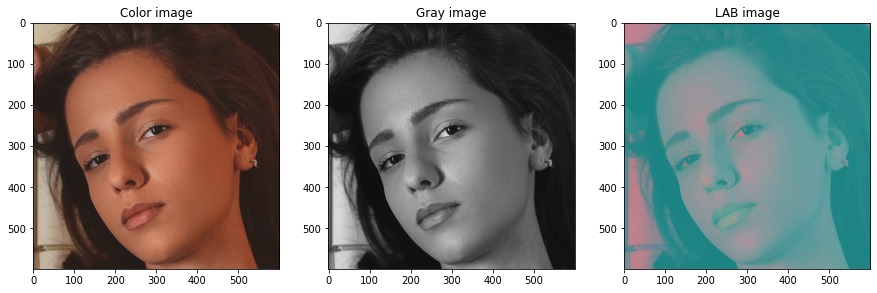

In [11]:
samples = len(input_img_paths)
idx = 25

img = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.subplot(131), plt.imshow(img)
plt.title("Color image")
plt.subplot(132), plt.imshow(grey, cmap='gray')
plt.title("Gray image")
plt.subplot(133), plt.imshow(img_lab)
plt.title("LAB image")

print(img.shape)

Text(0.5, 1.0, 'B channel')

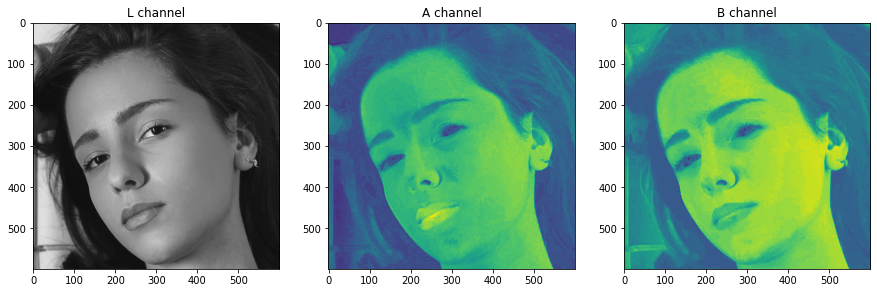

In [17]:
plt.subplot(131), plt.imshow(img_lab[:,:,0], cmap='gray')
plt.title("L channel")
plt.subplot(132), plt.imshow(img_lab[:,:,1])
plt.title("A channel")
plt.subplot(133), plt.imshow(img_lab[:,:,2])
plt.title("B channel")

In [18]:
img = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (input_size, input_size))
img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img = np.array(img, dtype=float)
img = (1.0/255*img)
# img_ab = img/128

# img = 255*img
# img = img.astype(np.uint8) 
# img = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)
# plt.imshow(img)

In [19]:
img_lab = img_lab/255.0
img_lab = cv2.resize(img_lab, (input_size, input_size))
# np.shape(img_lab[:,:,1:])
img_ab = img_lab[:,:,1:];
# reshape_img_lab = img_ab.reshape([1, input_size, input_size, 2])
reshape_img_lab = np.expand_dims(img_ab, axis=0)
reshape_img_lab.reshape(reshape_img_lab.shape[1:]).shape

(320, 320, 2)

In [21]:
# input_img_paths

Another model

In [ ]:
def ExtractInput(ImagePath):
    X_img=[]
    y_img=[]
    for imageDir in input_img_paths:
        try:
            img = cv2.imread(imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            #Convert the rgb values to the Lab format
 
            img_lab = img_lab/255.0
            img_lab_rs = cv2.resize(img_lab, (input_size, input_size)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:] # Extracting the ab channel
            # img_ab = (img_ab-0.5)/0.5 # Make values between -1 and 1
            #The true color values range between -128 and 128. This is the default interval 
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

X, y = ExtractInput(input_img_paths) # Data-preprocessing
X_train,X_val,y_train,y_val = train_test_split(X,y, random_state=42)

In [ ]:
def get_Alpha_model(input_size):
    inputs = layers.Input(shape=(input_size, input_size, 1))

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(inputs)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs, outputs)
    return model

A_model = get_Alpha_model(input_size)
A_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 160, 160, 8)       80        
                                                                 
 conv2d_19 (Conv2D)          (None, 160, 160, 8)       584       
                                                                 
 conv2d_20 (Conv2D)          (None, 160, 160, 16)      1168      
                                                                 
 conv2d_21 (Conv2D)          (None, 80, 80, 16)        2320      
                                                                 
 conv2d_22 (Conv2D)          (None, 80, 80, 32)        4640      
                                                                 
 conv2d_23 (Conv2D)          (None, 40, 40, 32)        9248  

In [ ]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = np.expand_dims(X[i], axis=0)
        y_input = np.expand_dims(y[i], axis=0)
        yield (X_input,y_input)

In [ ]:
A_model.compile(optimizer='rmsprop', loss='mse')
A_model.fit(GenerateInputs(X_train,y_train), epochs=30, verbose=1, steps_per_epoch=3, validation_data=GenerateInputs(X_val, y_val), shuffle=True)
# A_model.fit(x=X, y=Y, batch_size=1, epochs=3)
print(A_model.evaluate(X_val, y_val))

1/1 [==============================] - 0s 96ms/step


Text(0.5, 1.0, 'Ground truth')

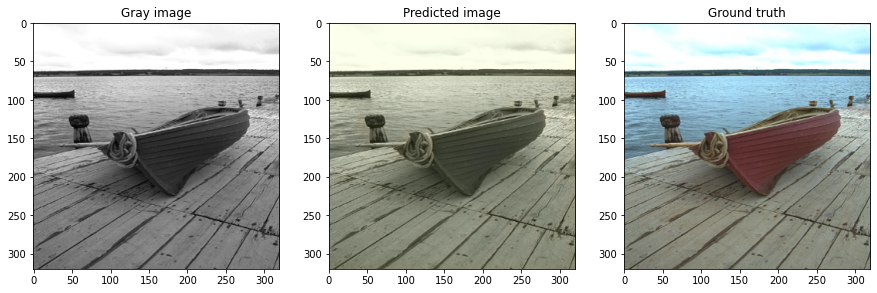

In [ ]:
idx = 30

img_rgb = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2RGB)
img_rgb = cv2.resize(img_rgb, (input_size, input_size))
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
img = (1.0/255*img)
gray = img[:,:,0]
gray = np.expand_dims(gray, axis=0)

output = A_model.predict(gray)

# gathering image chanels
new_img = np.zeros((input_size, input_size, 3))
new_img[:,:,0] = gray.reshape(gray.shape[1:])
new_img[:,:,1:] = output.reshape(output.shape[1:])
new_img = 255*new_img
new_img = new_img.astype(np.uint8)
new_img = cv2.cvtColor(new_img, cv2.COLOR_Lab2RGB)

plt.subplot(131), plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.title("Gray image")
plt.subplot(132), plt.imshow(new_img)
plt.title("Predicted image") 
plt.subplot(133), plt.imshow(img_rgb,)
plt.title("Ground truth") 

# output = A_model.predict(X)
# output = output * 128
# canvas = np.zeros((400, 400, 3))
# canvas[:,:,0] = X[0][:,:,0]
# canvas[:,:,1:] = output[0]
# canvas = 255*canvas
# canvas = canvas.astype(np.uint8) 
# canvas = cv2.cvtColor(canvas, cv2.COLOR_Lab2RGB)

# imsave("img_result.png", lab2rgb(canvas))
# imsave("img_gray_scale.png", rgb2gray(lab2rgb(canvas)))

End of model

In [ ]:
#Using U-Net architecture 

def get_U_model(input_size):
    # inputs = layers.Input(shape=img_size + (3,))
    # inputs = layers.Input(shape=img_size + (1,))
    inputs = layers.Input(shape=(input_size, input_size, 1))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add output layer with sigmoid activation function (result between 0 and 1)
    # outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
    # outputs = tf.nn.depth_to_space(x, 3)
    # outputs = layers.Conv2DTranspose(3, 5, activation="sigmoid", padding="same", data_format="channels_last")(x)
    outputs = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


# Build model
# model = get_model(img_size)
# model.summary()

In [ ]:
model = get_U_model(input_size)
model.summary()
# plot_model(model, show_shapes=True)

In [ ]:
# Data generator
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle

class PhotoGenerator(keras.utils.Sequence):    
    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to **batch** index."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img_gray = load_img(path, target_size=self.img_size + (1,), color_mode="grayscale")
            x[j] = np.expand_dims(img_gray, 2)
            img = load_img(path, target_size=self.img_size)
            y[j] = img
            
        return x/255, y/255
    
    def on_epoch_end(self):
        self.input_img_paths = shuffle(self.input_img_paths)

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = int(round(samples*0.2, 0))
random.Random(1337).shuffle(input_img_paths)

# Split data
train_input_img_paths = input_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]

# Instantiate data generators
train_gen = PhotoGenerator(batch_size, img_size, train_input_img_paths)
val_gen = PhotoGenerator(batch_size, img_size, val_input_img_paths)

In [ ]:
model.compile(optimizer="rmsprop", loss=tf.keras.losses.MeanSquaredError())
# callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

# A_model.compile(optimizer='rmsprop', loss='mse')
# A_model.fit(GenerateInputs(X_train,y_train), epochs=30, verbose=1, steps_per_epoch=3, validation_data=GenerateInputs(X_val, y_val), shuffle=True)
epochs = 30
model.fit(GenerateInputs(X_train,y_train), epochs=epochs, steps_per_epoch=3, validation_data=GenerateInputs(X_val, y_val))

Epoch 1/30
3/3 [==============================] - 5s 549ms/step - loss: 0.0159 - val_loss: 0.0961
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 0.0313

3/3 [==============================] - 0s 46ms/step - loss: 0.0313
Epoch 3/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0137
Epoch 4/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0041
Epoch 5/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0057
Epoch 6/30
3/3 [==============================] - 0s 33ms/step - loss: 0.0038
Epoch 7/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0028
Epoch 8/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0045
Epoch 9/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 10/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0041
Epoch 11/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0055
Epoch 12/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0043
Epoch 13/30
3/3 [==============================] - 0s 32ms/step - loss: 0.0019
Epoch 14/30
3/3 [==============================] - 0s 34ms/step - loss:

1/1 [==============================] - 0s 19ms/step


Text(0.5, 1.0, 'Ground truth')

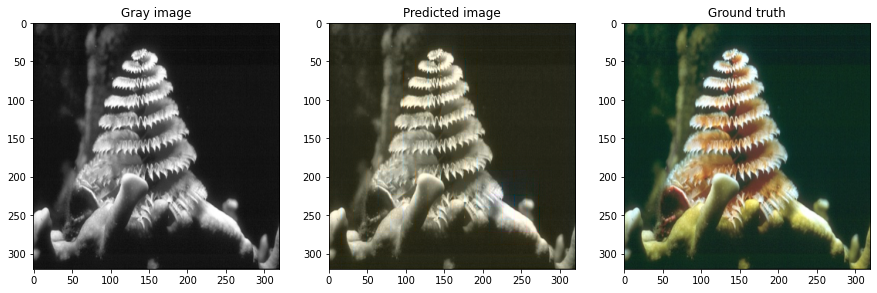

In [ ]:
idx = 20

img_rgb = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2RGB)
img_rgb = cv2.resize(img_rgb, (input_size, input_size))
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
img = (1.0/255*img)
gray = img[:,:,0]
gray = np.expand_dims(gray, axis=0)

output = model.predict(gray)

# gathering image chanels
new_img = np.zeros((input_size, input_size, 3))
new_img[:,:,0] = gray.reshape(gray.shape[1:])
new_img[:,:,1:] = output.reshape(output.shape[1:])
new_img = 255*new_img
new_img = new_img.astype(np.uint8)
new_img = cv2.cvtColor(new_img, cv2.COLOR_Lab2RGB)

plt.subplot(131), plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.title("Gray image")
plt.subplot(132), plt.imshow(new_img)
plt.title("Predicted image") 
plt.subplot(133), plt.imshow(img_rgb,)
plt.title("Ground truth") 

In [ ]:
val_gen = PhotoGenerator(batch_size, img_size, val_input_img_paths)
val_preds = model.predict(val_gen)

1/1 [==============================] - 12s 12s/step


(<matplotlib.axes._subplots.AxesSubplot at 0x7feeec0b3e80>,
 <matplotlib.image.AxesImage at 0x7feeec0990d0>)

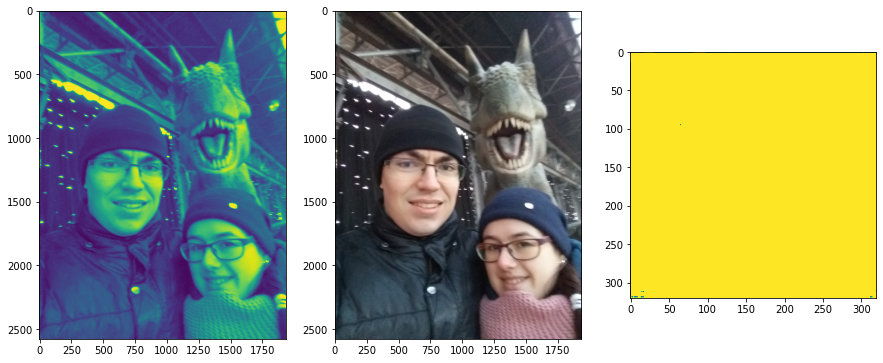

In [ ]:
idx = 10

x = load_img(val_input_img_paths[idx], color_mode="grayscale")
y_true = load_img(val_input_img_paths[idx])
y_pred = np.argmax(val_preds[idx], axis=-1)

plt.subplot(131), plt.imshow(x)
plt.subplot(132), plt.imshow(y_true)
plt.subplot(133), plt.imshow(y_pred)

In [ ]:
np.shape(y_pred)

(320, 320)